In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, countmap
using Statistics

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, Strategy, C

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="serif-roman",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
);

In [3]:
function area_C_rate(N::Int, strategy_mat::Matrix{Strategy}, t::Int, span::Int, rich_flag::Bool)::Float64
    # prime node or the poorest node
    prime_node_id = 1
    node = rich_flag ? prime_node_id : ((prime_node_id + Int(N / 2)) % N)

    strategy_vec = if node + span > N
        [strategy_mat[t, (node - span):N]; strategy_mat[t, 1:(node + span) % N]]
    elseif node - span < 1
        [strategy_mat[t, (node - span + N):N]; strategy_mat[t, 1:(node + span)]]
    else
        strategy_mat[t, (node - span):(node + span)]
    end

    return mean(strategy_vec .== C)
end

function moving_average(data::Vector{Float64}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

function calc_cross_cor(x::Vector{Float64}, y::Vector{Float64}, lag_vec::StepRange{Int64, Int64})::Vector{Float64}
    l = min(length(x), length(y))
    max_lag = maximum(lag_vec)

    if l <= max_lag
        @show x
        @show y
        return [0.0]
    end

    _x = x[(end - l + 1):end]
    _y = y[(end - l + 1):end]
    return [cor(_x[(max_lag+1):(end-max_lag)], _y[(max_lag+1+lag):(end-max_lag+lag)]) for lag in lag_vec]
end;

In [4]:
trials = 100
p = Param(
    N = 100,
    k₀ = 4,
    generations = 10_000,
    C_rate₀ = 0.0,
    relationship_increment_factor = 1.2,
    resource_decrement_factor = 0.02,
    resource_limit_μ = 0.5,
    b = 1.8,
    peak_node_variability = 0,
    resource_limit_β = 0.8,
    resource_limit_σ = 0.1,
)
C_rate_vec_vec = []
threshold_vec_vec = []
degree_mat_vec = []
strategy_mat_vec = []

# Execute simulations
for _ in 1:trials
    random_seed = rand(1:typemax(Int16))
    m = Model(p, MersenneTwister(random_seed))
    C_rate_vec, _, _, peak_node_vec, strategy_mat, degree_mat = run!(m, MersenneTwister(random_seed))

    push!(C_rate_vec_vec, C_rate_vec)
    push!(threshold_vec_vec, m.resource_limit_vec)
    push!(degree_mat_vec, degree_mat)
    push!(strategy_mat_vec, strategy_mat)
end;

In [5]:
time_lag_vec = -50:1:50
cross_cor_rich_C_rate_var_C_rate_var_vec_vec = []
cross_cor_poor_C_rate_var_C_rate_var_vec_vec = []
cross_cor_rich_C_rate_poor_C_rate_vec_vec = []
cross_cor_rich_C_rate_var_poor_C_rate_var_vec_vec = []
cross_cor_C_rate_hub_count_vec_vec = []
cross_cor_C_rate_degree_SD_vec_vec = []
# moving_θ_vec vs something
cross_cor_θ_C_rate_vec_vec = []
cross_cor_θ_C_rate_var_vec_vec = []
cross_cor_θ_rich_C_rate_vec_vec = []
cross_cor_θ_rich_C_rate_var_vec_vec = []
cross_cor_θ_poor_C_rate_vec_vec = []
cross_cor_θ_poor_C_rate_var_vec_vec = []
cross_cor_θ_hub_count_vec_vec = []
cross_cor_θ_degree_SD_vec_vec = []
# moving_θ_var_vec vs something
cross_cor_θ_var_C_rate_vec_vec = []
cross_cor_θ_var_C_rate_var_vec_vec = []
cross_cor_θ_var_rich_C_rate_vec_vec = []
cross_cor_θ_var_rich_C_rate_var_vec_vec = []
cross_cor_θ_var_poor_C_rate_vec_vec = []
cross_cor_θ_var_poor_C_rate_var_vec_vec = []
cross_cor_θ_var_hub_count_vec_vec = []
cross_cor_θ_var_degree_SD_vec_vec = []
cross_cor_mixed1_vec_vec = []

for i in 1:trials
    # Variables
    C_rate_vec = C_rate_vec_vec[i]
    # C_rate_vec = abs.(C_rate_vec_vec[i] .- 0.5)
    C_rate_var_vec = C_rate_vec[2:end] .- C_rate_vec[1:(end-1)]
    rich_C_rate_vec = [area_C_rate(p.N, strategy_mat_vec[i], t, 10, true) for t in 1:p.generations]
    rich_C_rate_var_vec = rich_C_rate_vec[2:end] .- rich_C_rate_vec[1:(end-1)]
    poor_C_rate_vec = [area_C_rate(p.N, strategy_mat_vec[i], t, 10, false) for t in 1:p.generations];
    poor_C_rate_var_vec = poor_C_rate_vec[2:end] .- poor_C_rate_vec[1:(end-1)]
    degree_mat = degree_mat_vec[i]
    degree_SD_vec = vec(std(degree_mat, dims=2))
    hub_count_vec = Float64.([sum(degree_mat[x, :] .>= 8) for x in 1:size(degree_mat, 1)])
    θ_vec = threshold_vec_vec[i]
    θ_var_vec = θ_vec[2:end] .- θ_vec[1:(end-1)]
    θ_abs_var_vec = abs.(θ_var_vec)
    mixed1_vec = (1 .- C_rate_vec) .* θ_vec

    # Moving average
    window_size = 10
    moving_C_rate_vec = moving_average(C_rate_vec, window_size)
    moving_C_rate_var_vec = moving_average(C_rate_var_vec, window_size)
    moving_rich_C_rate_vec = moving_average(rich_C_rate_vec, window_size)
    moving_rich_C_rate_var_vec = moving_average(rich_C_rate_var_vec, window_size)
    moving_poor_C_rate_vec = moving_average(poor_C_rate_vec, window_size)
    moving_poor_C_rate_var_vec = moving_average(poor_C_rate_var_vec, window_size)
    moving_degree_SD_vec = moving_average(degree_SD_vec, window_size)
    moving_hub_count_vec = moving_average(hub_count_vec, window_size)
    moving_θ_vec = moving_average(θ_vec, window_size)
    moving_θ_var_vec = moving_average(θ_var_vec, window_size)
    # moving_θ_var_vec = moving_average(θ_abs_var_vec, window_size)
    moving_mixed1_vec = moving_average(mixed1_vec, window_size)

    # Cross-correlation
    push!(cross_cor_rich_C_rate_var_C_rate_var_vec_vec,      calc_cross_cor(moving_rich_C_rate_var_vec, moving_C_rate_var_vec,      time_lag_vec))
    push!(cross_cor_poor_C_rate_var_C_rate_var_vec_vec,      calc_cross_cor(moving_poor_C_rate_var_vec, moving_C_rate_var_vec,      time_lag_vec))
    push!(cross_cor_rich_C_rate_poor_C_rate_vec_vec,         calc_cross_cor(moving_rich_C_rate_vec,     moving_poor_C_rate_vec,     time_lag_vec))
    push!(cross_cor_rich_C_rate_var_poor_C_rate_var_vec_vec, calc_cross_cor(moving_rich_C_rate_var_vec, moving_poor_C_rate_var_vec, time_lag_vec))
    push!(cross_cor_C_rate_hub_count_vec_vec,                calc_cross_cor(moving_C_rate_vec,          moving_hub_count_vec,       time_lag_vec))
    push!(cross_cor_C_rate_degree_SD_vec_vec,                calc_cross_cor(moving_C_rate_vec,          moving_degree_SD_vec,       time_lag_vec))
    # moving_θ_vec vs something
    push!(cross_cor_θ_C_rate_vec_vec,            calc_cross_cor(moving_θ_vec, moving_C_rate_vec,            time_lag_vec))
    push!(cross_cor_θ_C_rate_var_vec_vec,        calc_cross_cor(moving_θ_vec, moving_C_rate_var_vec,        time_lag_vec))
    push!(cross_cor_θ_rich_C_rate_vec_vec,       calc_cross_cor(moving_θ_vec, moving_rich_C_rate_vec,       time_lag_vec))
    push!(cross_cor_θ_rich_C_rate_var_vec_vec,   calc_cross_cor(moving_θ_vec, moving_rich_C_rate_var_vec,   time_lag_vec))
    push!(cross_cor_θ_poor_C_rate_vec_vec,       calc_cross_cor(moving_θ_vec, moving_poor_C_rate_vec,       time_lag_vec))
    push!(cross_cor_θ_poor_C_rate_var_vec_vec,   calc_cross_cor(moving_θ_vec, moving_poor_C_rate_var_vec,   time_lag_vec))
    push!(cross_cor_θ_hub_count_vec_vec,         calc_cross_cor(moving_θ_vec, moving_hub_count_vec,         time_lag_vec))
    push!(cross_cor_θ_degree_SD_vec_vec,         calc_cross_cor(moving_θ_vec, moving_degree_SD_vec,         time_lag_vec))
    # moving_θ_var_vec vs something
    push!(cross_cor_θ_var_C_rate_vec_vec,            calc_cross_cor(moving_θ_var_vec, moving_C_rate_vec,            time_lag_vec))
    push!(cross_cor_θ_var_C_rate_var_vec_vec,        calc_cross_cor(moving_θ_var_vec, moving_C_rate_var_vec,        time_lag_vec))
    push!(cross_cor_θ_var_rich_C_rate_vec_vec,       calc_cross_cor(moving_θ_var_vec, moving_rich_C_rate_vec,       time_lag_vec))
    push!(cross_cor_θ_var_rich_C_rate_var_vec_vec,   calc_cross_cor(moving_θ_var_vec, moving_rich_C_rate_var_vec,   time_lag_vec))
    push!(cross_cor_θ_var_poor_C_rate_vec_vec,       calc_cross_cor(moving_θ_var_vec, moving_poor_C_rate_vec,       time_lag_vec))
    push!(cross_cor_θ_var_poor_C_rate_var_vec_vec,   calc_cross_cor(moving_θ_var_vec, moving_poor_C_rate_var_vec,   time_lag_vec))
    push!(cross_cor_θ_var_hub_count_vec_vec,         calc_cross_cor(moving_θ_var_vec, moving_hub_count_vec,         time_lag_vec))
    push!(cross_cor_θ_var_degree_SD_vec_vec,         calc_cross_cor(moving_θ_var_vec, moving_degree_SD_vec,         time_lag_vec))
    # mixed
    push!(cross_cor_mixed1_vec_vec, calc_cross_cor(moving_mixed1_vec, moving_C_rate_var_vec, time_lag_vec))
end;

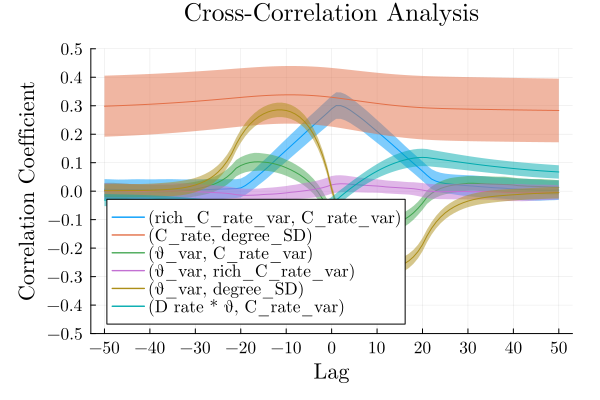

Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行


In [6]:
function add_cor_line!(plt::Plots.Plot, vec_vec::Vector, trials::Int, time_lag_vec::StepRange, label::String)::Nothing
    mean_vec = [mean([vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
    std_vec = [std([vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
    plot!(plt, time_lag_vec, mean_vec, ribbon=std_vec, label=label)
    return
end

# Plot base
plt = plot(
    xticks=minimum(time_lag_vec):10:maximum(time_lag_vec),
    xlabel="Lag",
    ylim=(-0.5, 0.5),
    yticks=-1.0:0.1:1.0,
    ylabel="Correlation Coefficient",
    title="Cross-Correlation Analysis",
    legend=:bottomleft,
)

# Plot cross-correlation
## 相関あり
add_cor_line!(plt, cross_cor_rich_C_rate_var_C_rate_var_vec_vec, trials, time_lag_vec, "(rich_C_rate_var, C_rate_var)")
# add_cor_line!(plt, cross_cor_poor_C_rate_var_C_rate_var_vec_vec, trials, time_lag_vec, "poor_C_rate_var_C_rate_var")
# add_cor_line!(plt, cross_cor_rich_C_rate_poor_C_rate_vec_vec, trials, time_lag_vec, "rich_C_rate_poor_C_rate")
# add_cor_line!(plt, cross_cor_rich_C_rate_var_poor_C_rate_var_vec_vec, trials, time_lag_vec, "rich_C_rate_var_poor_C_rate_var")
## 相関なし
# add_cor_line!(plt, cross_cor_C_rate_hub_count_vec_vec, trials, time_lag_vec, "(C_rate, hub_count)")
add_cor_line!(plt, cross_cor_C_rate_degree_SD_vec_vec, trials, time_lag_vec, "(C_rate, degree_SD)")

# moving_θ_vec vs something
## 相関なし
# add_cor_line!(plt, cross_cor_θ_C_rate_vec_vec, trials, time_lag_vec, "θ_C_rate")
# add_cor_line!(plt, cross_cor_θ_C_rate_var_vec_vec, trials, time_lag_vec, "θ_C_rate_var")
# add_cor_line!(plt, cross_cor_θ_C_rate_50diff_var_vec_vec, trials, time_lag_vec, "θ_C_rate_50diff_var")
# add_cor_line!(plt, cross_cor_θ_rich_C_rate_vec_vec, trials, time_lag_vec, "θ_rich_C_rate")
# add_cor_line!(plt, cross_cor_θ_rich_C_rate_var_vec_vec, trials, time_lag_vec, "θ_rich_C_rate_var")
# add_cor_line!(plt, cross_cor_θ_poor_C_rate_vec_vec, trials, time_lag_vec, "θ_poor_C_rate")
# add_cor_line!(plt, cross_cor_θ_poor_C_rate_var_vec_vec, trials, time_lag_vec, "θ_poor_C_rate_var")
## 相関あり
# add_cor_line!(plt, cross_cor_θ_hub_count_vec_vec, trials, time_lag_vec, "θ_hub_count")
# add_cor_line!(plt, cross_cor_θ_degree_SD_vec_vec, trials, time_lag_vec, "θ_degree_SD")

# moving_θ_var_vec vs something
## 相関なし
# add_cor_line!(plt, cross_cor_θ_var_C_rate_vec_vec, trials, time_lag_vec, "θ_var_C_rate")
add_cor_line!(plt, cross_cor_θ_var_C_rate_var_vec_vec, trials, time_lag_vec, "(θ_var, C_rate_var)")
# add_cor_line!(plt, cross_cor_θ_var_C_rate_50diff_var_vec_vec, trials, time_lag_vec, "θ_var_C_rate_50diff_var")
# add_cor_line!(plt, cross_cor_θ_var_rich_C_rate_vec_vec, trials, time_lag_vec, "θ_var_rich_C_rate")
add_cor_line!(plt, cross_cor_θ_var_rich_C_rate_var_vec_vec, trials, time_lag_vec, "(θ_var, rich_C_rate_var)")
# add_cor_line!(plt, cross_cor_θ_var_poor_C_rate_vec_vec, trials, time_lag_vec, "θ_var_poor_C_rate")
# add_cor_line!(plt, cross_cor_θ_var_poor_C_rate_var_vec_vec, trials, time_lag_vec, "θ_var_poor_C_rate_var")
## 相関あり
# add_cor_line!(plt, cross_cor_θ_var_hub_count_vec_vec, trials, time_lag_vec, "(θ_var, hub_count)")
add_cor_line!(plt, cross_cor_θ_var_degree_SD_vec_vec, trials, time_lag_vec, "(θ_var, degree_SD)")

# mixed
# 非協力率×閾値 vs 協力率変動
add_cor_line!(plt, cross_cor_mixed1_vec_vec, trials, time_lag_vec, "(D rate * θ, C_rate_var)")

display(plt)
savefig(plt, "img/cross_cor_universal.png")
println("Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行");

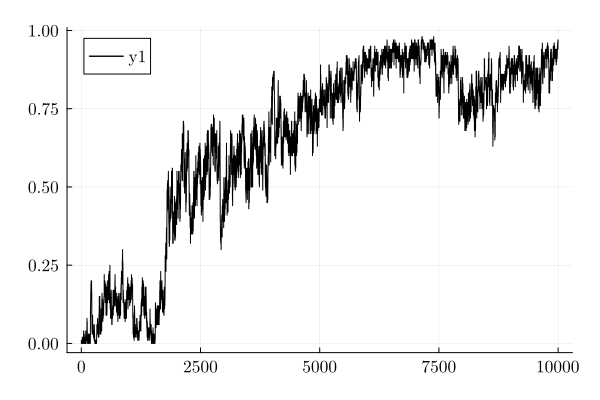

In [17]:
plot(C_rate_vec_vec[4], lc=:black)